In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import pytz

# Open datasets

## SOS Measurement Dataset

In [2]:
ls -lah | grep parquet | grep tidy_df

-rw-r--r--@   1 elischwat  staff    37M Apr  3 19:00 tidy_df_20221130_20230509_noplanar_fit.parquet
-rw-r--r--    1 elischwat  staff   257M Feb 20 22:02 tidy_df_20221130_20230509_noplanar_fit_ARCHIVE.parquet
-rw-r--r--@   1 elischwat  staff    50M Apr  3 18:06 tidy_df_20221130_20230509_noplanar_fit_clean.parquet


In [3]:
start_date = '20221130'
end_date = '20230509'
# open files
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

## Turbpy Model Ensemble Dataset

In [4]:
model_df = pd.read_parquet("model_results.parquet")
# add a bunch of columns that are descriptive, from the config column which has multiple bits of info
model_df['z0'] = model_df['config'].apply(
    lambda v: v.split(' ')[-1]
)
model_df['e_sat_curve'] = model_df['config'].apply(
    lambda v: 'metpy' if 'metpy' in v else 'alduchov'
)
model_df['surface_measurement'] = model_df['config'].apply(
    lambda v: v.split(' ')[-3]
)
model_df['scheme'] = model_df['config'].apply(
    lambda v: 'andreas' if 'andreas lengths' in v else 'yang'
)
model_df['most_config'] = model_df['config'].apply(lambda s: ' '.join(s.split(' ')[:-3]))
# remove the scalar roughness length parameterization info 
model_df['most_config'] = model_df['most_config'].str.replace(' andreas lengths', '')

model_df.head()

,config,time,sensible heat conductance,latent heat conductance,sensible heat flux,latent heat flux,stabilityCorrectionParameters,param_dict,z0,e_sat_curve,surface_measurement,scheme,most_config
0,Standard Tsurf_c e_sat_alduchov z0_andreas,2022-11-30,0.007876,7.875544e-03,-3.501763,-14.535007,"{'L': None, 'conductanceNeutral': 0.0023045755...","{'available_capping': ['no_capping', 'louis_Ri...",z0_andreas,alduchov,Tsurf_c,yang,Standard
1,MO Beljaars Holtslag andreas lengths Tsurf_d e...,2022-11-30,0.000968,2.834700e+06,18.697491,1.776961,"{'L': 4.942739184482242, 'conductanceNeutral':...","{'available_capping': ['no_capping', 'louis_Ri...",0.0001,alduchov,Tsurf_d,andreas,MO Beljaars Holtslag
2,MO Beljaars Holtslag andreas lengths Tsurf_rad...,2022-11-30,0.001104,2.834700e+06,15.329465,0.036198,"{'L': 7.380611525873046, 'conductanceNeutral':...","{'available_capping': ['no_capping', 'louis_Ri...",0.0001,alduchov,Tsurf_rad_d,andreas,MO Beljaars Holtslag
3,MO Cheng Brutsaert andreas lengths Tsurf_c e_s...,2022-11-30,0.001594,2.834700e+06,-2.357991,-9.986380,"{'L': -70.32408727166649, 'conductanceNeutral'...","{'available_capping': ['no_capping', 'louis_Ri...",0.0001,alduchov,Tsurf_c,andreas,MO Cheng Brutsaert
4,MO Cheng Brutsaert andreas lengths Tsurf_d e_s...,2022-11-30,0.000861,2.834700e+06,16.627654,1.578410,"{'L': 5.003304638752211, 'conductanceNeutral':...","{'available_capping': ['no_capping', 'louis_Ri...",0.0001,alduchov,Tsurf_d,andreas,MO Cheng Brutsaert


## COARE model results

In [5]:
ls -lah | grep parquet | grep coare

-rw-r--r--@   1 elischwat  staff   202M Apr  3 18:07 coare_model_results.parquet


In [6]:
coare_model_results = pd.read_parquet("coare_model_results.parquet").reset_index()
coare_model_results['z0'] = coare_model_results.config.str.split(' ').apply(lambda x: x[-2])
coare_model_results['meas_height'] = coare_model_results.config.str.split(' ').apply(lambda x: x[-1])
coare_model_results['surface_measurement'] = coare_model_results.config.str.split(' ').apply(lambda x: x[0])
coare_model_results['e_sat_curve'] = coare_model_results.config.str.split(' ').apply(lambda x: x[1])
coare_model_results.head(3)

,time,config,hsb,hlb,tau,zo,zot,zoq,L,usr,...,Chn_10,Cen_10,rr,rt,rq,hlb_gperm2s,z0,meas_height,surface_measurement,e_sat_curve
0,2022-11-30 00:00:00,Tsurf_c e_sat_alduchov z0_andreas 3m,1.954076,9.321132,0.025086,0.000704,0.000110,0.000136,-111.500877,0.163181,...,0.001466,0.001493,9.450727,1.448934,1.793207,0.003284,z0_andreas,3m,Tsurf_c,e_sat_alduchov
1,2022-11-30 00:30:00,Tsurf_c e_sat_alduchov z0_andreas 3m,0.588092,17.007415,0.041814,0.000460,0.000091,0.000111,-382.418956,0.209803,...,0.001380,0.001404,7.945250,1.541077,1.885541,0.005993,z0_andreas,3m,Tsurf_c,e_sat_alduchov
2,2022-11-30 01:00:00,Tsurf_c e_sat_alduchov z0_andreas 3m,-1.379165,12.636117,0.026424,0.000379,0.000125,0.000149,431.620638,0.166379,...,0.001392,0.001414,5.200889,1.710405,2.036584,0.004452,z0_andreas,3m,Tsurf_c,e_sat_alduchov


In [7]:
coare_model_results = coare_model_results[
    coare_model_results.surface_measurement.isin([
        'Tsurf_c', 'Tsurf_d', 'Tsurf_rad_d',
    ])
]

## Convert timezones for all datasets 

In [8]:
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, "US/Mountain")
model_df = utils.modify_df_timezone(model_df, pytz.UTC, "US/Mountain")
coare_model_results = utils.modify_df_timezone(coare_model_results, pytz.UTC, "US/Mountain")

In [9]:
from metpy.constants import density_water
seconds_in_timestep = 60*30

# Create a common dataset of model runs so that we compare across similar timestamps
(some datasets may have nans where others do not)

## Grab COARE and BA model runs we want to look at

In [10]:
coare_configs_we_want = [
    'Tsurf_c e_sat_alduchov 1e-05 3m',              'Tsurf_d e_sat_alduchov 1e-05 3m',              'Tsurf_rad_d e_sat_alduchov 1e-05 3m',
    'Tsurf_c e_sat_alduchov 5e-05 3m',              'Tsurf_d e_sat_alduchov 5e-05 3m',              'Tsurf_rad_d e_sat_alduchov 5e-05 3m',
    'Tsurf_c e_sat_alduchov 0.0001 3m',             'Tsurf_d e_sat_alduchov 0.0001 3m',             'Tsurf_rad_d e_sat_alduchov 0.0001 3m',
    'Tsurf_c e_sat_alduchov 0.0005 3m',             'Tsurf_d e_sat_alduchov 0.0005 3m',             'Tsurf_rad_d e_sat_alduchov 0.0005 3m',
    'Tsurf_c e_sat_alduchov 0.001 3m',              'Tsurf_d e_sat_alduchov 0.001 3m',              'Tsurf_rad_d e_sat_alduchov 0.001 3m',
    'Tsurf_c e_sat_alduchov 0.005 3m',              'Tsurf_d e_sat_alduchov 0.005 3m',              'Tsurf_rad_d e_sat_alduchov 0.005 3m',
    'Tsurf_c e_sat_alduchov z0_andreas 3m',         'Tsurf_d e_sat_alduchov z0_andreas 3m',         'Tsurf_rad_d e_sat_alduchov z0_andreas 3m',
    'Tsurf_c e_sat_alduchov z0_andreas_weekly 3m',  'Tsurf_d e_sat_alduchov z0_andreas_weekly 3m',  'Tsurf_rad_d e_sat_alduchov z0_andreas_weekly 3m',
]

In [11]:
coare_sum_model_results = coare_model_results[coare_model_results.config.isin(coare_configs_we_want)][['time', 'config', 'hlb_gperm2s']].pivot(
    index = 'time',
    columns = 'config',
    values = 'hlb_gperm2s'
).dropna()

In [12]:

# get rid of the string part that says 3m
coare_sum_model_results.columns = [ c[:-3] for c in coare_sum_model_results.columns]
coare_sum_model_results = coare_sum_model_results*seconds_in_timestep/density_water.magnitude
coare_sum_model_results.columns = [ f"COARE ({s})" for s in coare_sum_model_results.columns ]

In [13]:
ba_configs_we_want = [
    'Standard Tsurf_c e_sat_alduchov 1e-05',                'Standard Tsurf_d e_sat_alduchov 1e-05',                'Standard Tsurf_rad_d e_sat_alduchov 1e-05',
    'Standard Tsurf_c e_sat_alduchov 5e-05',                'Standard Tsurf_d e_sat_alduchov 5e-05',                'Standard Tsurf_rad_d e_sat_alduchov 5e-05',
    'Standard Tsurf_c e_sat_alduchov 0.0001',               'Standard Tsurf_d e_sat_alduchov 0.0001',               'Standard Tsurf_rad_d e_sat_alduchov 0.0001',
    'Standard Tsurf_c e_sat_alduchov 0.0005',               'Standard Tsurf_d e_sat_alduchov 0.0005',               'Standard Tsurf_rad_d e_sat_alduchov 0.0005',
    'Standard Tsurf_c e_sat_alduchov 0.001',                'Standard Tsurf_d e_sat_alduchov 0.001',                'Standard Tsurf_rad_d e_sat_alduchov 0.001',
    'Standard Tsurf_c e_sat_alduchov 0.005',                'Standard Tsurf_d e_sat_alduchov 0.005',                'Standard Tsurf_rad_d e_sat_alduchov 0.005',
    'Standard Tsurf_c e_sat_alduchov z0_andreas',           'Standard Tsurf_d e_sat_alduchov z0_andreas',           'Standard Tsurf_rad_d e_sat_alduchov z0_andreas',
    'Standard Tsurf_c e_sat_alduchov z0_andreas_weekly',    'Standard Tsurf_d e_sat_alduchov z0_andreas_weekly',    'Standard Tsurf_rad_d e_sat_alduchov z0_andreas_weekly',
]

In [14]:
ba_sum_model_results = model_df[model_df.config.isin(ba_configs_we_want)][['time', 'config', 'latent heat flux']]
ba_sum_model_results['latent heat flux'] = - ba_sum_model_results['latent heat flux']*seconds_in_timestep/density_water.magnitude/2838
ba_sum_model_results = ba_sum_model_results.pivot(
    index = 'time',
    columns = 'config',
    values = 'latent heat flux'
)
ba_sum_model_results.columns = [ f"BA ({s})" for s in ba_sum_model_results.columns ]

## Grab measured data we want

In [15]:
measured_results = tidy_df[tidy_df.variable.isin([
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',

    'w_h2o__3m_ue',
    'w_h2o__10m_ue',

    'w_h2o__3m_uw',
    'w_h2o__10m_uw',

    'w_h2o__3m_d',
    'w_h2o__10m_d',
])][
    ['time', 'value', 'variable']
]
measured_results.columns = ['time', 'measured', 'variable']
measured_results = measured_results.pivot(
    index = 'time',
    columns = 'variable',
    values = 'measured'
)
measured_results

variable,w_h2o__10m_c,w_h2o__10m_d,w_h2o__10m_ue,w_h2o__10m_uw,w_h2o__15m_c,w_h2o__20m_c,w_h2o__2m_c,w_h2o__3m_c,w_h2o__3m_d,w_h2o__3m_ue,w_h2o__3m_uw,w_h2o__5m_c
time,,,,,,,,,,,,
2022-11-29 17:00:00,0.010222,0.004838,0.005000,0.005185,0.006543,0.008915,0.001048,0.001886,0.000021,0.001953,-0.001564,0.003238
2022-11-29 17:30:00,0.002696,0.001688,0.000841,0.000025,0.000992,0.002328,-0.000204,0.000472,0.000443,0.001064,0.000375,0.001106
2022-11-29 18:00:00,0.000290,0.000816,0.001032,0.000011,0.000589,0.000469,-0.000630,-0.000584,-0.000096,-0.000492,-0.000422,-0.000531
2022-11-29 18:30:00,-0.002327,-0.001368,-0.001484,-0.002586,-0.001026,-0.001628,-0.001893,-0.001696,-0.001613,-0.001985,-0.001390,-0.001463
2022-11-29 19:00:00,-0.001898,-0.002339,-0.001968,-0.000251,-0.002219,-0.002594,-0.000490,-0.000566,-0.000725,-0.000980,-0.000500,-0.000536
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-09 15:30:00,0.011244,0.015525,0.010494,0.018161,NaN,NaN,0.009775,0.012305,0.022204,0.015058,0.017947,0.012981
2023-05-09 16:00:00,0.016920,0.008555,0.009996,0.012741,NaN,NaN,0.016499,0.017012,0.021434,0.017630,0.017168,0.018591
2023-05-09 16:30:00,0.006030,0.006757,0.002300,0.008597,NaN,NaN,0.007582,0.009711,0.010974,0.011369,0.008855,0.009151


### Fill in data gaps from the nearest sonic

In [16]:
print(len(measured_results['w_h2o__2m_c'].dropna()))
measured_results.loc[np.isnan(measured_results['w_h2o__2m_c']), 'w_h2o__2m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__2m_c']), 'w_h2o__3m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__2m_c']), 'w_h2o__2m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__2m_c']), 'w_h2o__5m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__2m_c']), 'w_h2o__2m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__2m_c']), 'w_h2o__10m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__2m_c']), 'w_h2o__2m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__2m_c']), 'w_h2o__15m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__2m_c']), 'w_h2o__2m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__2m_c']), 'w_h2o__20m_c']
print(len(measured_results['w_h2o__2m_c'].dropna()))

print(len(measured_results['w_h2o__3m_c'].dropna()))
measured_results.loc[np.isnan(measured_results['w_h2o__3m_c']), 'w_h2o__3m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__3m_c']), 'w_h2o__2m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__3m_c']), 'w_h2o__3m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__3m_c']), 'w_h2o__5m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__3m_c']), 'w_h2o__3m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__3m_c']), 'w_h2o__10m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__3m_c']), 'w_h2o__3m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__3m_c']), 'w_h2o__15m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__3m_c']), 'w_h2o__3m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__3m_c']), 'w_h2o__20m_c']
print(len(measured_results['w_h2o__3m_c'].dropna()))

print(len(measured_results['w_h2o__5m_c'].dropna()))
measured_results.loc[np.isnan(measured_results['w_h2o__5m_c']), 'w_h2o__5m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__5m_c']), 'w_h2o__10m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__5m_c']), 'w_h2o__5m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__5m_c']), 'w_h2o__3m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__5m_c']), 'w_h2o__5m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__5m_c']), 'w_h2o__2m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__5m_c']), 'w_h2o__5m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__5m_c']), 'w_h2o__15m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__5m_c']), 'w_h2o__5m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__5m_c']), 'w_h2o__20m_c']
print(len(measured_results['w_h2o__5m_c'].dropna()))

print(len(measured_results['w_h2o__10m_c'].dropna()))
measured_results.loc[np.isnan(measured_results['w_h2o__10m_c']), 'w_h2o__10m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__10m_c']), 'w_h2o__15m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__10m_c']), 'w_h2o__10m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__10m_c']), 'w_h2o__5m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__10m_c']), 'w_h2o__10m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__10m_c']), 'w_h2o__3m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__10m_c']), 'w_h2o__10m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__10m_c']), 'w_h2o__2m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__10m_c']), 'w_h2o__10m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__10m_c']), 'w_h2o__20m_c']
print(len(measured_results['w_h2o__10m_c'].dropna()))

print(len(measured_results['w_h2o__15m_c'].dropna()))
measured_results.loc[np.isnan(measured_results['w_h2o__15m_c']), 'w_h2o__15m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__15m_c']), 'w_h2o__20m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__15m_c']), 'w_h2o__15m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__15m_c']), 'w_h2o__10m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__15m_c']), 'w_h2o__15m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__15m_c']), 'w_h2o__5m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__15m_c']), 'w_h2o__15m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__15m_c']), 'w_h2o__3m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__15m_c']), 'w_h2o__15m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__15m_c']), 'w_h2o__2m_c']
print(len(measured_results['w_h2o__15m_c'].dropna()))

print(len(measured_results['w_h2o__20m_c'].dropna()))
measured_results.loc[np.isnan(measured_results['w_h2o__20m_c']), 'w_h2o__20m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__20m_c']), 'w_h2o__15m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__20m_c']), 'w_h2o__20m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__20m_c']), 'w_h2o__10m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__20m_c']), 'w_h2o__20m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__20m_c']), 'w_h2o__5m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__20m_c']), 'w_h2o__20m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__20m_c']), 'w_h2o__3m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__20m_c']), 'w_h2o__20m_c'] = measured_results.loc[np.isnan(measured_results['w_h2o__20m_c']), 'w_h2o__2m_c']
print(len(measured_results['w_h2o__20m_c'].dropna()))

print(len(measured_results['w_h2o__3m_ue'].dropna()))
measured_results.loc[np.isnan(measured_results['w_h2o__3m_ue']), 'w_h2o__3m_ue'] = measured_results.loc[np.isnan(measured_results['w_h2o__3m_ue']), 'w_h2o__3m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__3m_ue']), 'w_h2o__3m_ue'] = measured_results.loc[np.isnan(measured_results['w_h2o__3m_ue']), 'w_h2o__3m_uw']
measured_results.loc[np.isnan(measured_results['w_h2o__3m_ue']), 'w_h2o__3m_ue'] = measured_results.loc[np.isnan(measured_results['w_h2o__3m_ue']), 'w_h2o__3m_d']
print(len(measured_results['w_h2o__3m_ue'].dropna()))

print(len(measured_results['w_h2o__10m_ue'].dropna()))
measured_results.loc[np.isnan(measured_results['w_h2o__10m_ue']), 'w_h2o__10m_ue'] = measured_results.loc[np.isnan(measured_results['w_h2o__10m_ue']), 'w_h2o__10m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__10m_ue']), 'w_h2o__10m_ue'] = measured_results.loc[np.isnan(measured_results['w_h2o__10m_ue']), 'w_h2o__10m_uw']
measured_results.loc[np.isnan(measured_results['w_h2o__10m_ue']), 'w_h2o__10m_ue'] = measured_results.loc[np.isnan(measured_results['w_h2o__10m_ue']), 'w_h2o__10m_d']
print(len(measured_results['w_h2o__10m_ue'].dropna()))

print(len(measured_results['w_h2o__3m_uw'].dropna()))
measured_results.loc[np.isnan(measured_results['w_h2o__3m_uw']), 'w_h2o__3m_uw'] = measured_results.loc[np.isnan(measured_results['w_h2o__3m_uw']), 'w_h2o__3m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__3m_uw']), 'w_h2o__3m_uw'] = measured_results.loc[np.isnan(measured_results['w_h2o__3m_uw']), 'w_h2o__3m_ue']
measured_results.loc[np.isnan(measured_results['w_h2o__3m_uw']), 'w_h2o__3m_uw'] = measured_results.loc[np.isnan(measured_results['w_h2o__3m_uw']), 'w_h2o__3m_d']
print(len(measured_results['w_h2o__3m_uw'].dropna()))

print(len(measured_results['w_h2o__10m_uw'].dropna()))
measured_results.loc[np.isnan(measured_results['w_h2o__10m_uw']), 'w_h2o__10m_uw'] = measured_results.loc[np.isnan(measured_results['w_h2o__10m_uw']), 'w_h2o__10m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__10m_uw']), 'w_h2o__10m_uw'] = measured_results.loc[np.isnan(measured_results['w_h2o__10m_uw']), 'w_h2o__10m_ue']
measured_results.loc[np.isnan(measured_results['w_h2o__10m_uw']), 'w_h2o__10m_uw'] = measured_results.loc[np.isnan(measured_results['w_h2o__10m_uw']), 'w_h2o__10m_d']
print(len(measured_results['w_h2o__10m_uw'].dropna()))

print(len(measured_results['w_h2o__3m_d'].dropna()))
measured_results.loc[np.isnan(measured_results['w_h2o__3m_d']), 'w_h2o__3m_d'] = measured_results.loc[np.isnan(measured_results['w_h2o__3m_d']), 'w_h2o__3m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__3m_d']), 'w_h2o__3m_d'] = measured_results.loc[np.isnan(measured_results['w_h2o__3m_d']), 'w_h2o__3m_ue']
measured_results.loc[np.isnan(measured_results['w_h2o__3m_d']), 'w_h2o__3m_d'] = measured_results.loc[np.isnan(measured_results['w_h2o__3m_d']), 'w_h2o__3m_uw']
print(len(measured_results['w_h2o__3m_d'].dropna()))

print(len(measured_results['w_h2o__10m_d'].dropna()))
measured_results.loc[np.isnan(measured_results['w_h2o__10m_d']), 'w_h2o__10m_d'] = measured_results.loc[np.isnan(measured_results['w_h2o__10m_d']), 'w_h2o__10m_c']
measured_results.loc[np.isnan(measured_results['w_h2o__10m_d']), 'w_h2o__10m_d'] = measured_results.loc[np.isnan(measured_results['w_h2o__10m_d']), 'w_h2o__10m_ue']
measured_results.loc[np.isnan(measured_results['w_h2o__10m_d']), 'w_h2o__10m_d'] = measured_results.loc[np.isnan(measured_results['w_h2o__10m_d']), 'w_h2o__10m_uw']
print(len(measured_results['w_h2o__10m_d'].dropna()))

7027
7610
7043
7610
7366
7610
7217
7610
7262
7610
6979
7610
6915
7616
6822
7613
6980
7616
6829
7613
6770
7616
6845
7613


### Convert to mm

In [17]:
measured_results = measured_results*seconds_in_timestep/density_water.magnitude

Note how many timestamps are missing

In [18]:
print(len(ba_sum_model_results.dropna()))
print(len(coare_sum_model_results.dropna()))
print(len(measured_results.dropna()))

6354
6098
7610


## Safely combine datasets

### First create joined dataset of 30min data

In [19]:
# join results
joined_results_df = measured_results.join(
    ba_sum_model_results
).join(
    coare_sum_model_results
)
# Remove timestamps from all datasets that is NaN in any of the datasets
print(len(joined_results_df), len(joined_results_df.dropna()))
joined_sums_df = joined_results_df.dropna().sum()

7728 6093


### Second create joined dataset of seasonal sums

In [20]:



joined_sums_df = pd.DataFrame(
    joined_sums_df
).reset_index().rename(columns = {0:'mm', 'index':'variable'})

joined_sums_df.variable = joined_sums_df.variable.apply(
    lambda s: s.replace(
        "(z0_andreas)", "(z₀(t))"
    ).replace(
        "(z0_andreas_weekly)", "(z₀ᵂ(t))",
    )
)
joined_sums_df

,variable,mm
0,w_h2o__10m_c,36.773865
1,w_h2o__10m_d,33.058608
2,w_h2o__10m_ue,29.989510
3,w_h2o__10m_uw,36.464101
4,w_h2o__15m_c,28.614788
5,w_h2o__20m_c,27.298750
6,w_h2o__2m_c,30.851710
7,w_h2o__3m_c,33.575290
8,w_h2o__3m_d,34.364661
9,w_h2o__3m_ue,33.496422


# Plot Measured cumulative sums

In [21]:
meas_df = joined_results_df[[
    'w_h2o__10m_c', 'w_h2o__15m_c', 'w_h2o__20m_c', 'w_h2o__2m_c',
       'w_h2o__3m_c', 'w_h2o__5m_c',

        'w_h2o__3m_ue',
        'w_h2o__10m_ue',

        'w_h2o__3m_uw',
        'w_h2o__10m_uw',

        'w_h2o__3m_d',
        'w_h2o__10m_d',
       ]]
meas_df = meas_df.cumsum().reset_index()
meas_df = meas_df.melt(id_vars='time')
meas_df['height'] = meas_df['variable'].apply(lambda s: int(s.split('__')[1].split('m')[0]))
meas_df['tower'] = meas_df['variable'].apply(lambda s: s.split('__')[1].split('_')[-1])
meas_df['tower-height'] = meas_df['tower'] + '-' + meas_df['height'].astype('str')
meas_df


,time,variable,value,height,tower,tower-height
0,2022-11-29 17:00:00,w_h2o__10m_c,0.018399,10,c,c-10
1,2022-11-29 17:30:00,w_h2o__10m_c,0.023251,10,c,c-10
2,2022-11-29 18:00:00,w_h2o__10m_c,0.023773,10,c,c-10
3,2022-11-29 18:30:00,w_h2o__10m_c,0.019585,10,c,c-10
4,2022-11-29 19:00:00,w_h2o__10m_c,0.016168,10,c,c-10
...,...,...,...,...,...,...
92731,2023-05-09 15:30:00,w_h2o__10m_d,36.618750,10,d,d-10
92732,2023-05-09 16:00:00,w_h2o__10m_d,36.634149,10,d,d-10
92733,2023-05-09 16:30:00,w_h2o__10m_d,36.646312,10,d,d-10
92734,2023-05-09 17:00:00,w_h2o__10m_d,36.665484,10,d,d-10


# Plot Modeled Seasonal Totals, TurbPy and COARE, constant and variable z0 values

In [22]:
horiz_rules_base = alt.Chart(
    joined_sums_df[joined_sums_df.variable.str.contains('w_h2o_')]
).mark_rule(strokeDash=[2,2])

horiz_rules_chart = horiz_rules_base.encode(
    alt.Y("min(mm):Q")
) + horiz_rules_base.encode(
    alt.Y("max(mm):Q")
) + alt.Chart(
    joined_sums_df[joined_sums_df.variable == 'w_h2o__3m_c']
).mark_rule(strokeDash=[2,2]).encode(
    alt.Y("mm:Q")
)

In [23]:
modeled_sums_df = joined_sums_df[~joined_sums_df.variable.str.contains('w_h2o_')]
modeled_sums_df['method'] = modeled_sums_df.variable.apply(lambda s: s.split(' ')[0])
modeled_sums_df['z0'] = modeled_sums_df.variable.apply(lambda s: s.split(' ')[-1][:-1])
modeled_sums_df['Ts'] = modeled_sums_df.variable.apply(lambda s: s.split('Tsurf_')[1].split(' ')[0])
modeled_sums_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_80031/1475347923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeled_sums_df['method'] = modeled_sums_df.variable.apply(lambda s: s.split(' ')[0])
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_80031/1475347923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeled_sums_df['z0'] = modeled_sums_df.variable.apply(lambda s: s.split(' ')[-1][:-1])
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_80031/1475347923.py:4: 

,variable,mm,method,z0,Ts
12,BA (Standard Tsurf_c e_sat_alduchov 0.0001),48.508767,BA,0.0001,c
13,BA (Standard Tsurf_c e_sat_alduchov 0.0005),68.951714,BA,0.0005,c
14,BA (Standard Tsurf_c e_sat_alduchov 0.001),81.963850,BA,0.001,c
15,BA (Standard Tsurf_c e_sat_alduchov 0.005),131.226734,BA,0.005,c
16,BA (Standard Tsurf_c e_sat_alduchov 1e-05),32.030010,BA,1e-05,c
17,BA (Standard Tsurf_c e_sat_alduchov 5e-05),42.414295,BA,5e-05,c
18,BA (Standard Tsurf_c e_sat_alduchov z0_andreas),48.852126,BA,z0_andreas,c
19,BA (Standard Tsurf_c e_sat_alduchov z0_andreas...,43.136756,BA,z0_andreas_weekly,c
20,BA (Standard Tsurf_d e_sat_alduchov 0.0001),45.902697,BA,0.0001,d
21,BA (Standard Tsurf_d e_sat_alduchov 0.0005),65.272819,BA,0.0005,d


In [24]:
z0_sort = ['1e-05', '5e-05', '0.0001', '0.0005', '0.001', '0.005', 
"z₀(t)", "z₀ᵂ(t)"]

combined_model_chart = (
    alt.Chart(modeled_sums_df).mark_point(size=50).encode(
        alt.X("z0:O").sort(z0_sort).axis(labelAngle=-45),
        alt.Y("mm:Q").scale(zero=False),
        alt.Shape("method:N").scale(domain=['BA', 'COARE'], range=['stroke', "circle"]),
        alt.Color("Ts:N"),
    )
).properties(width = 300, height = 300, title='COARE Algorithm (ticks) and Bulk Aerodynamic (dots)') + horiz_rules_chart
combined_model_chart.save("combined_model_chart.png", ppi=200)
combined_model_chart

alt.LayerChart(...)

# Surface temperature analysis

In [25]:
tsurfs = tidy_df[tidy_df.variable.isin([
    'Tsurf_c',
    'Tsurf_d',
    'Tsurf_rad_d',
])].pivot(
    index = 'time',
    columns = 'variable',
    values = 'value'
).dropna()
tsurfs = tsurfs[
    (tsurfs.Tsurf_c<50) & (tsurfs.Tsurf_c>-50) &
    (tsurfs.Tsurf_d<50) & (tsurfs.Tsurf_d>-50) &
    (tsurfs.Tsurf_rad_d<50) & (tsurfs.Tsurf_rad_d>-50)
]
from sklearn.metrics import r2_score

In [26]:
alt.Chart(tsurfs).mark_circle(size=10, opacity=0.25).encode(
    alt.X("Tsurf_c"),
    alt.Y("Tsurf_d")
) | alt.Chart(tsurfs).mark_circle(size=10, opacity=0.25).encode(
    alt.X("Tsurf_c"),
    alt.Y("Tsurf_rad_d")
) | alt.Chart(tsurfs).mark_circle(size=10, opacity=0.25).encode(
    alt.X("Tsurf_d"),
    alt.Y("Tsurf_rad_d")
)

alt.HConcatChart(...)

In [27]:
r2_score(tsurfs['Tsurf_c'], tsurfs['Tsurf_d']), np.mean(np.abs(tsurfs['Tsurf_c'] - tsurfs['Tsurf_d'])), np.median(np.abs(tsurfs['Tsurf_c'] - tsurfs['Tsurf_d']))

(0.9533961744528334, 0.6447458992507906, 0.198150634765625)

In [28]:
r2_score(tsurfs['Tsurf_rad_d'], tsurfs['Tsurf_d']), np.mean(np.abs(tsurfs['Tsurf_rad_d'] - tsurfs['Tsurf_d'])), np.median(np.abs(tsurfs['Tsurf_rad_d'] - tsurfs['Tsurf_d']))

(0.9527978157426679, 1.3706209673063325, 1.283111572265625)

In [29]:
r2_score(tsurfs['Tsurf_rad_d'], tsurfs['Tsurf_c']), np.mean(np.abs(tsurfs['Tsurf_rad_d'] - tsurfs['Tsurf_c'])), np.median(np.abs(tsurfs['Tsurf_rad_d'] - tsurfs['Tsurf_c']))

(0.9349043924124852, 1.516045686061243, 1.380035400390625)

In [30]:
time_no_day = tsurfs.reset_index().time.apply(lambda dt:dt.replace(year=2000, month=1, day=1))
tsurfs['time_no_day'] = pd.to_datetime(time_no_day)

In [31]:
tsurfs['Tsurf_d - Tsurf_rad_d'] = tsurfs.Tsurf_d - tsurfs.Tsurf_rad_d
tsurfs['Tsurf_d - Tsurf_c'] = tsurfs.Tsurf_d - tsurfs.Tsurf_c

In [32]:
temp_difference_diurnal_chart = alt.Chart(
    tsurfs.reset_index()
).transform_fold(
    ['Tsurf_d - Tsurf_rad_d',
    'Tsurf_d - Tsurf_c' ]
).mark_errorbar().encode(
    alt.X("hoursminutes(time):T"),
    alt.Y("value:Q").title("T difference"),
    alt.Row("key:N").title("")
).properties(width=250, height=100)
temp_difference_diurnal_chart.save("temp_difference_diurnal_chart.png", ppi=200)
temp_difference_diurnal_chart

alt.Chart(...)

# Combine our 3 sources of information (measured data, turbpy models, COARE models) and compare with Stossel box data

In [33]:
# COARE
coare_model_results
# TURBPY
model_results_for_stossel_comparison = model_df.query("e_sat_curve == 'alduchov'").query("scheme == 'andreas'").query("surface_measurement == 'Tsurf_c'").query("most_config == 'MO Holtslag de Bruin'")
model_results_for_stossel_comparison = model_results_for_stossel_comparison[['time', 'latent heat flux', 'z0']]
model_results_for_stossel_comparison = model_results_for_stossel_comparison.set_index('time').tz_localize(None).reset_index()

# MEASUREMENTS
measurements_for_stossel_comparison = tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')[['value']].rename(columns={'value': 'measured'})

In [34]:
lysimeter_data = pd.read_csv("../sos/processed_lysimeter_data.csv")
lysimeter_data['time'] = pd.to_datetime(lysimeter_data['time'])
lysimeter_data['time_previous'] = pd.to_datetime(lysimeter_data['time_previous'])
lysimeter_data.head()

,Unnamed: 0,time_previous,time,delta_box_mean_mm,daytime
0,8,2023-02-03 16:26:00,2023-02-04 07:55:00,0.021063,False
1,9,2023-02-04 07:55:00,2023-02-04 16:30:00,-0.048646,True
2,10,2023-02-04 16:30:00,2023-02-05 08:02:00,0.013541,False
3,13,2023-02-07 12:28:00,2023-02-07 17:28:00,-0.044634,True
4,15,2023-02-09 17:00:00,2023-02-10 08:00:00,0.015547,False


In [35]:
combined_results_df = pd.DataFrame()
for i, row in lysimeter_data.iterrows():
    tprev = row['time_previous']
    t = row['time'] 
    
    # collect coare data
    this_coare_data = coare_model_results.set_index('time').sort_index().loc[tprev: t].pivot_table(
        index='time',
        values=['hlb_gperm2s'],
        columns='z0'
    )
    this_coare_data.columns = ['coare (z0=' + col + ')' for col in this_coare_data.columns.get_level_values(1)]
    this_coare_data = this_coare_data.sum()
    
    # collect turbpy data
    this_turbpy_data = model_results_for_stossel_comparison.set_index('time').sort_index().loc[tprev: t].pivot_table(
            index='time',
            values=['latent heat flux'],
            columns='z0'
    )
    this_turbpy_data.columns = ['turbpy (z0=' + col + ')' for col in this_turbpy_data.columns.get_level_values(1)]
    this_turbpy_data = this_turbpy_data.sum()

    # measured data
    this_ec_data = measurements_for_stossel_comparison.loc[tprev: t].sum()

    this_measurement_df = pd.DataFrame(pd.concat([
        this_coare_data,
        this_turbpy_data,
        this_ec_data.rename({'measured': 'EC measured'}),
        # make this negative to match the other stuff
        - row[['delta_box_mean_mm']].rename({'delta_box_mean_mm': 'Lysimeter measured'})
    ])).reset_index().rename(columns={
        0: 'lh flux (mm)',
        'index': 'measurement'
    })
    this_measurement_df['time'] = row['time']
    this_measurement_df['time_previous'] = row['time_previous']
    this_measurement_df['daytime'] = row['daytime']
    combined_results_df = pd.concat([combined_results_df, this_measurement_df])

Make the "lost mass" measurements from the stossel box positive

In [36]:
combined_results_df['type'] = combined_results_df['measurement'].apply(lambda s: s.split(' ')[0])
combined_results_df

,measurement,lh flux (mm),time,time_previous,daytime,type
0,coare (z0=0.0001),-0.001517,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
1,coare (z0=0.0005),-0.001808,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
2,coare (z0=0.001),-0.002007,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
3,coare (z0=0.005),-0.002895,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
4,coare (z0=1e-05),-0.001261,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
...,...,...,...,...,...,...
13,turbpy (z0=5e-05),54.015878,2023-02-18 08:10:00,2023-02-17 17:05:00,False,turbpy
14,turbpy (z0=z0_andreas),45.559308,2023-02-18 08:10:00,2023-02-17 17:05:00,False,turbpy
15,turbpy (z0=z0_andreas_weekly),66.010365,2023-02-18 08:10:00,2023-02-17 17:05:00,False,turbpy
16,EC measured,-0.010488,2023-02-18 08:10:00,2023-02-17 17:05:00,False,EC


In [37]:
combined_results_df

,measurement,lh flux (mm),time,time_previous,daytime,type
0,coare (z0=0.0001),-0.001517,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
1,coare (z0=0.0005),-0.001808,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
2,coare (z0=0.001),-0.002007,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
3,coare (z0=0.005),-0.002895,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
4,coare (z0=1e-05),-0.001261,2023-02-04 07:55:00,2023-02-03 16:26:00,False,coare
...,...,...,...,...,...,...
13,turbpy (z0=5e-05),54.015878,2023-02-18 08:10:00,2023-02-17 17:05:00,False,turbpy
14,turbpy (z0=z0_andreas),45.559308,2023-02-18 08:10:00,2023-02-17 17:05:00,False,turbpy
15,turbpy (z0=z0_andreas_weekly),66.010365,2023-02-18 08:10:00,2023-02-17 17:05:00,False,turbpy
16,EC measured,-0.010488,2023-02-18 08:10:00,2023-02-17 17:05:00,False,EC


In [38]:
(alt.Chart(combined_results_df.query("daytime == True").query("type != 'turbpy'")).mark_tick().encode(
    alt.X("type:N").sort(['Lysimeter', 'EC', 'coare']),
    alt.Y("lh flux (mm)"),
    alt.Column('time:T'),
).properties(height = 100) & alt.Chart(combined_results_df.query("daytime == False").query("type != 'turbpy'")).mark_tick().encode(
    alt.X("type:N"),
    alt.Y("lh flux (mm)"),
    alt.Column('time:T'),
).properties(height = 100)).display(renderer='svg')

alt.VConcatChart(...)

## plot wind speeds, lh flux profiles, theta_v profiles, to see if on Feb 7, 11, 12, advection is likely, while on Feb 4, 10, 17 it seems less likely

In [39]:
case_studies_advective = pd.concat([
    tidy_df.set_index('time').loc['20230207': '20230207'],
])
case_studies_advective['day'] = case_studies_advective.index.day

case_studies_normal = pd.concat([
    tidy_df.set_index('time').loc['20230204': '20230204'],
    tidy_df.set_index('time').loc['20230210': '20230210'],
    tidy_df.set_index('time').loc['20230217': '20230217']
])

case_studies_normal['day'] = case_studies_normal.index.day

In [40]:
winddir_chart = alt.Chart(
    case_studies_advective.query("measurement == 'wind direction'").reset_index()
).transform_filter(
    alt.datum.tower == 'c'
).transform_filter(
    alt.FieldOneOfPredicate('height', [3,10,20])
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:O"),
    alt.Column("day:O")
).properties(width=200, height = 200).resolve_scale(x='independent')

bsflux_chart = alt.Chart(
    case_studies_advective.query("measurement == 'snow flux'").reset_index().query("value > 0")
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(type='log'),
    alt.Color("height:O"),
    alt.Column("day:O")
).properties(width=200, height = 50).resolve_scale(x='independent')

profiles_src = case_studies_advective.query("measurement == 'w_h2o_'").query("tower == 'c'").reset_index()
profiles_src = profiles_src.set_index("time").groupby([
    pd.Grouper(freq='240Min'), 'height', 'day'
]).mean(numeric_only=True).reset_index()
profiles_src['hour'] = profiles_src.time.dt.hour

lhflux_profiles_chart = alt.Chart(
    profiles_src    
).mark_line().encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height:Q"),
    alt.Color("hour:O").scale(scheme='rainbow'),
    alt.Column("day:O")
).resolve_scale(color='shared').properties(width=200, height = 200)

profiles_src = case_studies_advective.query("measurement == 'potential virtual temperature'").query("tower == 'c'").reset_index()
profiles_src = profiles_src.set_index("time").groupby([
    pd.Grouper(freq='240Min'), 'height', 'day'
]).mean(numeric_only=True).reset_index()
profiles_src['hour'] = profiles_src.time.dt.hour

thetav_profiles_chart = alt.Chart(
    profiles_src    
).mark_line().encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height:Q"),
    alt.Color("hour:O").scale(scheme='rainbow'),
    alt.Column("day:O")
).resolve_scale(color='shared').properties(width=200, height = 200)

(bsflux_chart & winddir_chart & lhflux_profiles_chart & thetav_profiles_chart).resolve_scale(color='independent')

alt.VConcatChart(...)

In [41]:
winddir_chart = alt.Chart(
    case_studies_normal.query("measurement == 'wind direction'").reset_index()
).transform_filter(
    alt.datum.tower == 'c'
).transform_filter(
    alt.FieldOneOfPredicate('height', [3,10,20])
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:O"),
    alt.Column("day:O")
).properties(width=200, height = 200).resolve_scale(x='independent')

bsflux_chart = alt.Chart(
    case_studies_normal.query("measurement == 'snow flux'").reset_index().query("value > 0")
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(type='log'),
    alt.Color("height:O"),
    alt.Column("day:O")
).properties(width=200, height = 50).resolve_scale(x='independent')

profiles_src = case_studies_normal.query("measurement == 'w_h2o_'").query("tower == 'c'").reset_index()
profiles_src = profiles_src.set_index("time").groupby([
    pd.Grouper(freq='240Min'), 'height', 'day'
]).mean(numeric_only=True).reset_index()
profiles_src['hour'] = profiles_src.time.dt.hour

lhflux_profiles_chart = alt.Chart(
    profiles_src    
).mark_line().encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height:Q"),
    alt.Color("hour:O").scale(scheme='rainbow'),
    alt.Column("day:O")
).resolve_scale(color='shared').properties(width=200, height = 200)

profiles_src = case_studies_normal.query("measurement == 'potential virtual temperature'").query("tower == 'c'").reset_index()
profiles_src = profiles_src.set_index("time").groupby([
    pd.Grouper(freq='240Min'), 'height', 'day'
]).mean(numeric_only=True).reset_index()
profiles_src['hour'] = profiles_src.time.dt.hour

thetav_profiles_chart = alt.Chart(
    profiles_src    
).mark_line().encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height:Q"),
    alt.Color("hour:O").scale(scheme='rainbow'),
    alt.Column("day:O")
).resolve_scale(color='shared').properties(width=200, height = 200)

(bsflux_chart & winddir_chart & lhflux_profiles_chart & thetav_profiles_chart).resolve_scale(color='independent')

alt.VConcatChart(...)

# Calculate statistics

## Create dataset, combining measured data with model results from different sources  

Use a subset of TurbPy results, all the COARE results, and measured data at 3m on tower c, the tower and height of measurements used to run the models

### Turbpy models

In [42]:
# select_turbpy_results_df = model_df[
#     model_df['config'].isin([
#         'MO Holtslag de Bruin andreas lengths Tsurf_c e_sat_alduchov 1e-05',
#         'MO Holtslag de Bruin andreas lengths Tsurf_c e_sat_alduchov 0.0001',
#         'MO Holtslag de Bruin andreas lengths Tsurf_c e_sat_alduchov 0.0005',
#         'MO Holtslag de Bruin andreas lengths Tsurf_c e_sat_alduchov z0_andreas',
#         'MO Holtslag de Bruin andreas lengths Tsurf_c e_sat_alduchov z0_andreas_weekly',
#     ]) 
# ]
# select_turbpy_results_df['z0'] = select_turbpy_results_df['z0'].astype('str')
# select_turbpy_results_df = select_turbpy_results_df[['time', 'z0', 'latent heat flux']].pivot_table(
#     index='time', columns='z0',
# )
# select_turbpy_results_df.columns = select_turbpy_results_df.columns.to_flat_index().str.join('_')
# select_turbpy_results_df = select_turbpy_results_df.loc[:'2023-05-09']
# select_turbpy_results_df.columns = select_turbpy_results_df.columns.to_series().apply(lambda s: f"turbpy (z0 = {s.split('_')[-1]})").values
# select_turbpy_results_df

### Measured data

In [43]:
measured_df = tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')[['value']].rename(columns={'value': 'measured'})
measured_df_10m = tidy_df.query("variable == 'w_h2o__10m_c'").set_index('time')[['value']].rename(columns={'value': 'measured (10m)'})
measured_df = pd.merge(
    measured_df.reset_index(),
    measured_df_10m.reset_index(),
    on='time'
).set_index('time')

### NOAA/COARE Models

In [44]:
select_coare_results_df = coare_model_results[['time', 'config', 'hlb_gperm2s']].pivot(index='time', columns='config')
select_coare_results_df.columns = select_coare_results_df.columns.droplevel(0)
select_coare_results_df = select_coare_results_df[[
    "Tsurf_c e_sat_alduchov 0.0001 3m",
    "Tsurf_c e_sat_alduchov 0.0005 3m",
    "Tsurf_c e_sat_alduchov 1e-05 3m",
    "Tsurf_c e_sat_alduchov z0_andreas 3m",	
    "Tsurf_c e_sat_alduchov z0_andreas_weekly 3m"
]].rename(columns = {
    "Tsurf_c e_sat_alduchov 0.0001 3m": "coare (z0 = 0.0001)",
    "Tsurf_c e_sat_alduchov 0.0005 3m": "coare (z0 = 0.0005)",
    "Tsurf_c e_sat_alduchov 1e-05 3m": "coare (z0 = 1e-05)",
    "Tsurf_c e_sat_alduchov z0_andreas 3m": "coare (z0 = andreas)",
    "Tsurf_c e_sat_alduchov z0_andreas_weekly 3m": "coare (z0 = weekly)",

})



### Combine it all

In [45]:
# select_turbpy_results_df = select_turbpy_results_df.reset_index('time')
# select_turbpy_results_df['time'] = select_turbpy_results_df['time'].dt.tz_localize(None)
# select_turbpy_results_df = select_turbpy_results_df.set_index('time')

# model_meas_df = measured_df.join(
#     select_turbpy_results_df,
#     how = 'left'
# ).join(
#     select_coare_results_df,
#     how = 'left'
# )
model_meas_df = measured_df.join(
    select_coare_results_df,
    how = 'left'
)
model_meas_nonans_df = model_meas_df.dropna()
model_meas_nonans_df

,measured,measured (10m),coare (z0 = 0.0001),coare (z0 = 0.0005),coare (z0 = 1e-05),coare (z0 = andreas),coare (z0 = weekly)
time,,,,,,,
2022-11-29 17:00:00,0.001886,0.010222,0.002683,0.003205,0.002000,0.003284,0.003048
2022-11-29 17:30:00,0.000472,0.002696,0.005121,0.006029,0.003883,0.005993,0.005760
2022-11-29 18:00:00,-0.000584,0.000290,0.003810,0.004560,0.002844,0.004452,0.004330
2022-11-29 18:30:00,-0.001696,-0.002327,0.000935,0.001178,0.000660,0.000904,0.001086
2022-11-29 19:00:00,-0.000566,-0.001898,0.000252,0.000325,0.000174,0.000421,0.000296
...,...,...,...,...,...,...,...
2023-05-09 15:30:00,0.012305,0.011244,0.005524,0.007381,0.003915,0.002816,0.004527
2023-05-09 16:00:00,0.017012,0.016920,0.009247,0.012050,0.006548,0.009891,0.007607
2023-05-09 16:30:00,0.009711,0.006030,0.002380,0.003122,0.001766,0.001990,0.001990


In [46]:
model_meas_nonans_df.sum()*30*60/density_water.magnitude

measured                34.482732
measured (10m)          38.603788
coare (z0 = 0.0001)     38.513652
coare (z0 = 0.0005)     46.536295
coare (z0 = 1e-05)      28.158511
coare (z0 = andreas)    32.033330
coare (z0 = weekly)     32.980534
dtype: float64

## Do statistics calculations
1. Mean Absolute Error
2. Mean Relative Error
3. R^2
4. NSE


In [47]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
# define a function for Nash Sutcliffe
def nse(targets, predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2))

In [48]:
def get_stats_df(df, data_desc):
    return pd.DataFrame([
            # [data_desc, 'ME', "turbpy (z0 = 1e-05)", (df["turbpy (z0 = 1e-05)"] - df["measured"]).values.mean() ],
            # # [data_desc, 'ME', "turbpy (z0 = 0.0001)", (df["turbpy (z0 = 0.0001)"] - df["measured"]).values.mean() ],
            # # [data_desc, 'ME', "turbpy (z0 = 0.0005)", (df["turbpy (z0 = 0.0005)"] - df["measured"]).values.mean() ],
            # # [data_desc, 'ME', "turbpy (z0 = andreas)", (df["turbpy (z0 = andreas)"] - df["measured"]).values.mean() ],
            # # [data_desc, 'ME', "turbpy (z0 = weekly)", (df["turbpy (z0 = weekly)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "coare (z0 = 1e-05)", (df["coare (z0 = 1e-05)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "coare (z0 = 0.0001)", (df["coare (z0 = 0.0001)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "coare (z0 = 0.0005)", (df["coare (z0 = 0.0005)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "coare (z0 = andreas)", (df["coare (z0 = andreas)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "coare (z0 = weekly)", (df["coare (z0 = weekly)"] - df["measured"]).values.mean() ],
            
            # # [data_desc, 'MAE', "turbpy (z0 = 1e-05)", mean_absolute_error(df["measured"], df["turbpy (z0 = 1e-05)"])],
            # # [data_desc, 'MAE', "turbpy (z0 = 0.0001)", mean_absolute_error(df["measured"], df["turbpy (z0 = 0.0001)"])],
            # # [data_desc, 'MAE', "turbpy (z0 = 0.0005)", mean_absolute_error(df["measured"], df["turbpy (z0 = 0.0005)"])],
            # # [data_desc, 'MAE', "turbpy (z0 = andreas)", mean_absolute_error(df["measured"], df["turbpy (z0 = andreas)"])],
            # # [data_desc, 'MAE', "turbpy (z0 = weekly)", mean_absolute_error(df["measured"], df["turbpy (z0 = weekly)"])],
            [data_desc, 'MAE', "coare (z0 = 1e-05)", mean_absolute_error(df["measured"], df["coare (z0 = 1e-05)"])],
            [data_desc, 'MAE', "coare (z0 = 0.0001)", mean_absolute_error(df["measured"], df["coare (z0 = 0.0001)"])],
            [data_desc, 'MAE', "coare (z0 = 0.0005)", mean_absolute_error(df["measured"], df["coare (z0 = 0.0005)"])],
            [data_desc, 'MAE', "coare (z0 = andreas)", mean_absolute_error(df["measured"], df["coare (z0 = andreas)"])],
            [data_desc, 'MAE', "coare (z0 = weekly)", mean_absolute_error(df["measured"], df["coare (z0 = weekly)"])],
        
            # # [data_desc, 'MAPE', "turbpy (z0 = 1e-05)", mean_absolute_percentage_error(df["measured"], df["turbpy (z0 = 1e-05)"])],
            # # [data_desc, 'MAPE', "turbpy (z0 = 0.0001)", mean_absolute_percentage_error(df["measured"], df["turbpy (z0 = 0.0001)"])],
            # # [data_desc, 'MAPE', "turbpy (z0 = 0.0005)", mean_absolute_percentage_error(df["measured"], df["turbpy (z0 = 0.0005)"])],
            # # [data_desc, 'MAPE', "turbpy (z0 = andreas)", mean_absolute_percentage_error(df["measured"], df["turbpy (z0 = andreas)"])],
            # # [data_desc, 'MAPE', "turbpy (z0 = weekly)", mean_absolute_percentage_error(df["measured"], df["turbpy (z0 = weekly)"])],
            [data_desc, 'MAPE', "coare (z0 = 1e-05)", mean_absolute_percentage_error(df["measured"], df["coare (z0 = 1e-05)"])],
            [data_desc, 'MAPE', "coare (z0 = 0.0001)", mean_absolute_percentage_error(df["measured"], df["coare (z0 = 0.0001)"])],
            [data_desc, 'MAPE', "coare (z0 = 0.0005)", mean_absolute_percentage_error(df["measured"], df["coare (z0 = 0.0005)"])],
            [data_desc, 'MAPE', "coare (z0 = andreas)", mean_absolute_percentage_error(df["measured"], df["coare (z0 = andreas)"])],
            [data_desc, 'MAPE', "coare (z0 = weekly)", mean_absolute_percentage_error(df["measured"], df["coare (z0 = weekly)"])],

            # # [data_desc, 'r2', "turbpy (z0 = 1e-05)", r2_score(df["measured"], df["turbpy (z0 = 1e-05)"])],
            # # [data_desc, 'r2', "turbpy (z0 = 0.0001)", r2_score(df["measured"], df["turbpy (z0 = 0.0001)"])],
            # # [data_desc, 'r2', "turbpy (z0 = 0.0005)", r2_score(df["measured"], df["turbpy (z0 = 0.0005)"])],
            # # [data_desc, 'r2', "turbpy (z0 = andreas)", r2_score(df["measured"], df["turbpy (z0 = andreas)"])],
            # # [data_desc, 'r2', "turbpy (z0 = weekly)", r2_score(df["measured"], df["turbpy (z0 = weekly)"])],
            [data_desc, 'r2', "coare (z0 = 1e-05)", r2_score(df["measured"], df["coare (z0 = 1e-05)"])],
            [data_desc, 'r2', "coare (z0 = 0.0001)", r2_score(df["measured"], df["coare (z0 = 0.0001)"])],
            [data_desc, 'r2', "coare (z0 = 0.0005)", r2_score(df["measured"], df["coare (z0 = 0.0005)"])],
            [data_desc, 'r2', "coare (z0 = andreas)", r2_score(df["measured"], df["coare (z0 = andreas)"])],
            [data_desc, 'r2', "coare (z0 = weekly)", r2_score(df["measured"], df["coare (z0 = weekly)"])],
            
            # # [data_desc, 'NSE', "turbpy (z0 = 1e-05)", nse(df["measured"], df["turbpy (z0 = 1e-05)"])],
            # # [data_desc, 'NSE', "turbpy (z0 = 0.0001)", nse(df["measured"], df["turbpy (z0 = 0.0001)"])],
            # # [data_desc, 'NSE', "turbpy (z0 = 0.0005)", nse(df["measured"], df["turbpy (z0 = 0.0005)"])],
            # # [data_desc, 'NSE', "turbpy (z0 = andreas)", nse(df["measured"], df["turbpy (z0 = andreas)"])],
            # # [data_desc, 'NSE', "turbpy (z0 = weekly)", nse(df["measured"], df["turbpy (z0 = weekly)"])],
            [data_desc, 'NSE', "coare (z0 = 1e-05)", nse(df["measured"], df["coare (z0 = 1e-05)"])],
            [data_desc, 'NSE', "coare (z0 = 0.0001)", nse(df["measured"], df["coare (z0 = 0.0001)"])],
            [data_desc, 'NSE', "coare (z0 = 0.0005)", nse(df["measured"], df["coare (z0 = 0.0005)"])],
            [data_desc, 'NSE', "coare (z0 = andreas)", nse(df["measured"], df["coare (z0 = andreas)"])],
            [data_desc, 'NSE', "coare (z0 = weekly)", nse(df["measured"], df["coare (z0 = weekly)"])],
            
            
        ], 
        columns=['data desc', 'statistic', 'model', 'value']
    )

# Plot Statistical Results

### For different coupling regimes (using the decoupling metric) (following Peltola et al., 2021)

In [49]:
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query(
    "value >= 0.61"
).time

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query(
    "value < 0.43"
).time

weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query(
    "value < 0.61 & value >= 0.43"
).time

blowing_snow_times = pd.concat([
    tidy_df.query("variable == 'SF_avg_2m_ue'").query("value > 0").time,
    tidy_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
])

clear_times = tidy_df.query("variable == 'SF_avg_2m_ue'").time[
    ~ tidy_df.query("variable == 'SF_avg_2m_ue'").time.isin(blowing_snow_times)
]

In [50]:
all_stats_df = pd.concat([
    get_stats_df(model_meas_nonans_df, data_desc='all'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)], data_desc='decoupled'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)], data_desc='weakly coupled'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)], data_desc='coupled'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)], data_desc='bs'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)], data_desc='no bs'),
])

In [51]:
print(len(model_meas_nonans_df))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)]))

6990
2534
754
2906
1582
5408


In [52]:
all_stats_df.query("statistic == 'NSE'")

,data desc,statistic,model,value
20,all,NSE,coare (z0 = 1e-05),0.578794
21,all,NSE,coare (z0 = 0.0001),0.622225
22,all,NSE,coare (z0 = 0.0005),0.581172
23,all,NSE,coare (z0 = andreas),0.509650
24,all,NSE,coare (z0 = weekly),0.595500
20,decoupled,NSE,coare (z0 = 1e-05),0.030133
21,decoupled,NSE,coare (z0 = 0.0001),-0.011905
22,decoupled,NSE,coare (z0 = 0.0005),-0.075604
23,decoupled,NSE,coare (z0 = andreas),-0.021910
24,decoupled,NSE,coare (z0 = weekly),0.002854


In [53]:
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'ME'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAPE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'r2'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'NSE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100)

alt.VConcatChart(...)

In [54]:
coare_model_results_statistics_plot = alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'ME'
).mark_bar().encode(
    alt.X("value:Q").title("Mean Error (g/m^2/s)"),
    alt.Y("model:N"),
    alt.Row("statistic:N").header(None),
    alt.Column("data desc:N").sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns']).title(None)
).properties(width=100, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'NSE'
).mark_bar().encode(
    alt.X("value:Q").title("NSE"),
    alt.Y("model:N"),
    alt.Row("statistic:N").header(None),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=100, height = 100)
coare_model_results_statistics_plot.save("coare_model_results_statistics_plot.png", ppi=200)
coare_model_results_statistics_plot

alt.VConcatChart(...)

In [55]:
src = all_stats_df[all_stats_df['data desc'].isin(['all', 'bs', 'no bs'])]
src = src[src.model == 'coare (z0 = andreas)']

coare_model_results_statistics_plot = alt.Chart(src).transform_filter(
    alt.datum.statistic == 'ME'
).mark_bar().encode(
    alt.Y("value:Q").title("Mean Error (g/m^2/s)").scale(domain=[0,-0.0006]),
    alt.X("data desc:N").title("Data subset").axis(labelAngle=0)
).properties(width=100, height = 100) |\
alt.Chart(src).transform_filter(
    alt.datum.statistic == 'NSE'
).mark_bar().encode(
    alt.Y("value:Q").title(["Nash-Sutcliffe", "Efficiency"]),
    alt.X("data desc:N").title("Data subset").axis(labelAngle=0)
).properties(width=100, height = 100)
coare_model_results_statistics_plot.save("generalexam_coare_model_statistics.png", ppi=200)
coare_model_results_statistics_plot

alt.HConcatChart(...)

In [97]:
(model_meas_nonans_df['measured (10m)'] * 30*60/1000).sum()

38.60282126362743

In [99]:
(model_meas_nonans_df['measured'] * 30*60/1000).sum()

34.481868584170755

In [95]:
(model_meas_nonans_df['coare (z0 = andreas)'] * 30*60/1000).sum()

32.0325277437261

In [57]:
round(all_stats_df.query("statistic == 'ME'").pivot(
    index='model',
    columns='data desc',
    values='value'
)*1000, 2).style.set_caption("Mean Error, mg/m^2/s").format('{:.2f}')

data desc,all,bs,coupled,decoupled,no bs,weakly coupled
model,,,,,,
coare (z0 = 0.0001),0.32,0.09,-0.08,0.29,0.39,0.46
coare (z0 = 0.0005),0.96,1.32,1.08,0.32,0.85,0.67
coare (z0 = 1e-05),-0.50,-1.58,-1.56,0.24,-0.19,0.22
coare (z0 = andreas),-0.19,-0.57,-1.07,0.30,-0.09,0.26
coare (z0 = weekly),-0.12,-0.64,-0.88,0.26,0.03,0.32


In [58]:
round(all_stats_df.query("statistic == 'NSE'").pivot(
    index='model',
    columns='data desc',
    values='value'
), 2).style.set_caption("Nash-Sutcliffe Model Efficiency").format('{:.2f}')

data desc,all,bs,coupled,decoupled,no bs,weakly coupled
model,,,,,,
coare (z0 = 0.0001),0.62,0.66,0.68,-0.01,0.54,0.40
coare (z0 = 0.0005),0.58,0.61,0.66,-0.08,0.49,0.23
coare (z0 = 1e-05),0.58,0.57,0.58,0.03,0.51,0.46
coare (z0 = andreas),0.51,0.51,0.50,-0.02,0.42,0.36
coare (z0 = weekly),0.60,0.63,0.62,0.00,0.51,0.42


In [59]:
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'ME'
).mark_bar().encode(
    alt.Y("value:Q"),
    alt.X("model:N").axis(labelAngle=-45),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'NSE'
).mark_bar().encode(
    alt.Y("value:Q"),
    alt.X("model:N").axis(labelAngle=-45),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100)

alt.VConcatChart(...)

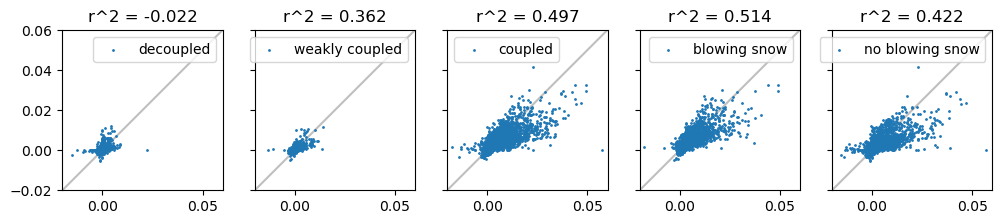

In [60]:
fig, axes = plt.subplots(1,5, figsize=(12,3), sharex=True, sharey=True)

axes[0].scatter(
    model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]['measured'],
    model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]['coare (z0 = andreas)'],
    s=1,
    label='decoupled'
)
axes[0].set_title(
    f"r^2 = {round(r2_score(
        model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]['measured'],
        model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]['coare (z0 = andreas)'],
    ), 3)}"
)
axes[1].scatter(
    model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]['measured'],
    model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]['coare (z0 = andreas)'],
    s=1,
    label='weakly coupled'
)
axes[1].set_title(
    f"r^2 = {round(r2_score(
        model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]['measured'],
        model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]['coare (z0 = andreas)'],
    ), 3)}"
)
axes[2].scatter(
    model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]['measured'],
    model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]['coare (z0 = andreas)'],
    s=1,
    label='coupled'
)
axes[2].set_title(
    f"r^2 = {round(r2_score(
        model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]['measured'],
        model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]['coare (z0 = andreas)'],
    ), 3)}"
)
axes[3].scatter(
    model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)]['measured'],
    model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)]['coare (z0 = andreas)'],
    s=1,
    label='blowing snow'
)
axes[3].set_title(
    f"r^2 = {round(r2_score(
        model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)]['measured'],
        model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)]['coare (z0 = andreas)'],
    ), 3)}"
)
axes[4].scatter(
    model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)]['measured'],
    model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)]['coare (z0 = andreas)'],
    s=1,
    label='no blowing snow'
)
axes[4].set_title(
    f"r^2 = {round(r2_score(
        model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)]['measured'],
        model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)]['coare (z0 = andreas)'],
    ), 3)}"
)


for ax in axes:
    ax.plot([-0.02,0.06],[-0.02,0.06], color='grey', alpha=0.5, zorder=-1)
    ax.set_xlim(-0.02,0.06)
    ax.set_ylim(-0.02,0.06)
    ax.set_aspect('equal')
    ax.legend()

In [61]:
model_meas_df

,measured,measured (10m),coare (z0 = 0.0001),coare (z0 = 0.0005),coare (z0 = 1e-05),coare (z0 = andreas),coare (z0 = weekly)
time,,,,,,,
2022-11-29 17:00:00,0.001886,0.010222,0.002683,0.003205,0.002000,0.003284,0.003048
2022-11-29 17:30:00,0.000472,0.002696,0.005121,0.006029,0.003883,0.005993,0.005760
2022-11-29 18:00:00,-0.000584,0.000290,0.003810,0.004560,0.002844,0.004452,0.004330
2022-11-29 18:30:00,-0.001696,-0.002327,0.000935,0.001178,0.000660,0.000904,0.001086
2022-11-29 19:00:00,-0.000566,-0.001898,0.000252,0.000325,0.000174,0.000421,0.000296
...,...,...,...,...,...,...,...
2023-05-09 15:30:00,0.012305,0.011244,0.005524,0.007381,0.003915,0.002816,0.004527
2023-05-09 16:00:00,0.017012,0.016920,0.009247,0.012050,0.006548,0.009891,0.007607
2023-05-09 16:30:00,0.009711,0.006030,0.002380,0.003122,0.001766,0.001990,0.001990


In [62]:
def model_comparison_plot(src):
    one_to_one_line = alt.Chart(pd.DataFrame({
        'x': [-0.05, -0.025, 0.0, 0.025, 0.05],
        'y': [-0.05, -0.025, 0.0, 0.025, 0.05]
    })).mark_line(
        color='grey'
    ).encode(x = 'x', y = 'y')

    value_r2_score_1eneg4 = round(
        r2_score(
            src.dropna()['measured'],
            src.dropna()['coare (z0 = andreas)'],
        ),
        3
    )
    value_r2_score_1eneg5 = round(
        r2_score(
            src.dropna()['measured'],
            src.dropna()['coare (z0 = weekly)'],
        ),
        3
    )
    scale = alt.Scale(domain = [-0.05, 0.05], clamp=True)
    axis = alt.Axis(values=[-0.05, -0.025, 0.0, 0.025, 0.05])
    return (
        # (
        #     one_to_one_line+alt.Chart(src).mark_circle(size=10, opacity=0.1).encode(
        #         alt.X("measured:Q").scale(scale).axis(axis),
        #         alt.Y("coare (z0 = andreas):Q").scale(scale).axis(axis),
        #     ).properties(width=200, height = 200, title=f"r² = {value_r2_score_1eneg4} (n = {len(src)})") | \
        #     one_to_one_line+alt.Chart(src).mark_rect().encode(
        #         alt.X("measured:Q").bin(maxbins=30).scale(scale).axis(axis),
        #         alt.Y("coare (z0 = andreas):Q").bin(maxbins=30).scale(scale).axis(axis),
        #         alt.Color("count():Q")
        #     ).properties(width=200, height = 200, title=f"r² = {value_r2_score_1eneg4} (n = {len(src)})")
        # ) &\
        (
            one_to_one_line+alt.Chart(src).mark_circle(size=10, opacity=0.1).encode(
                alt.X("measured:Q").scale(scale).axis(axis),
                alt.Y("coare (z0 = weekly):Q").scale(scale).axis(axis),
            ).properties(width=200, height = 200, title=f"r² = {value_r2_score_1eneg5} (n = {len(src)})") | \
            one_to_one_line+alt.Chart(src).mark_rect().encode(
                alt.X("measured:Q").bin(maxbins=30).scale(scale).axis(axis),
                alt.Y("coare (z0 = weekly):Q").bin(maxbins=30).scale(scale).axis(axis),
                alt.Color("count():Q")
            ).properties(width=200, height = 200, title=f"r² = {value_r2_score_1eneg5} (n = {len(src)})")   
        )
    )

In [63]:
winter_times = tidy_df.query("variable == 'SF_avg_2m_ue'").set_index("time").loc[:"2023-02-28"].index.values
spring_times = tidy_df.query("variable == 'SF_avg_2m_ue'").set_index("time").loc["2023-03-01":].index.values

In [64]:
model_comparison_plot(model_meas_df)

alt.HConcatChart(...)

In [65]:
model_meas_df = model_meas_df.reset_index()

In [66]:
(
model_comparison_plot(model_meas_df[model_meas_df.time.isin(blowing_snow_times.values)]).properties(title='Blowing snow data') |\
model_comparison_plot(model_meas_df[model_meas_df.time.isin(clear_times.values)]).properties(title='Clear data')).resolve_scale(color='independent')

alt.HConcatChart(...)

In [67]:
(
model_comparison_plot(model_meas_df[model_meas_df.time.isin(winter_times)]).properties(title='Winter data') |\
model_comparison_plot(model_meas_df[model_meas_df.time.isin(spring_times)]).properties(title='Spring data')).resolve_scale(color='independent')

alt.HConcatChart(...)

# Plot Case Studies

In [68]:
# from sublimpy import tidy
# ## Add combined blowing snow variable to dataset
# tidy_df = tidy.tidy_df_add_variable(
#     tidy_df,
#     (
#         tidy_df.query("variable == 'SF_avg_1m_ue'")['value'].values + 
#         tidy_df.query("variable == 'SF_avg_2m_ue'")['value'].values
#     ), 
#     'SF_avg_ue',
#     'snow flux',
#     1,
#     'ue',
# )

In [69]:
bs_data = tidy_df[tidy_df.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])].pivot(index='time', columns='variable', values='value')
bs_data['SF_avg_ue'] = bs_data['SF_avg_1m_ue'] + bs_data['SF_avg_2m_ue']
bs_data = bs_data.reset_index()

#### pull in particle calculations of blowing snow sublimation (see ../paper2/particle_sublimation.ipynb)

In [81]:
bs_sublimation_df = pd.read_csv("../paper2/bs_sublimation_20221220_20221224.csv")
bs_sublimation_df.time = pd.to_datetime(bs_sublimation_df.time)

In [82]:
start = '2022-12-20'
end = '2022-12-24'
model_meas_src = model_meas_df[ (model_meas_df.time > start)  & (model_meas_df.time < end) ]
bs_flux_src = bs_data[ (bs_data.time > start)  & (bs_data.time < end) ]
bs_flux_src['SF_avg_ue'] = bs_flux_src['SF_avg_ue'].replace(0, np.nan)
bs_flux_src['SF_avg_1m_ue'] = bs_flux_src['SF_avg_1m_ue'].replace(0, np.nan)
bs_flux_src['SF_avg_2m_ue'] = bs_flux_src['SF_avg_2m_ue'].replace(0, np.nan)
bs_flux_src = bs_flux_src.rename(columns={
    'SF_avg_1m_ue': '1',
    'SF_avg_2m_ue': '2'
})
tidy_df_casestudy1 = tidy_df[ (tidy_df.time > start)  & (tidy_df.time < end) ]
diag_src = tidy_df_casestudy1[tidy_df_casestudy1.variable.isin([
    'ldiag_3m_c',
    'ldiag_5m_c',
    'ldiag_10m_c',
    'ldiag_15m_c',
    'ldiag_20m_c',
])]

model_meas_src = model_meas_src[[
    'time',
    'measured',
    'measured (10m)',
    'coare (z0 = andreas)'
]].rename(columns={
    'measured'              : 'EC (3m)',
    'measured (10m)'        : 'EC (10m)',
    'coare (z0 = andreas)'  : 'MP',
})


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_80031/2239239580.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_flux_src['SF_avg_ue'] = bs_flux_src['SF_avg_ue'].replace(0, np.nan)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_80031/2239239580.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_flux_src['SF_avg_1m_ue'] = bs_flux_src['SF_avg_1m_ue'].replace(0, np.nan)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_80031/2239239580.py:7: SettingWithCopyWarning: 
A

In [83]:
model_meas_src = model_meas_src.merge(
    bs_sublimation_df[['time', 'bs_sublimation_flux']].rename(columns={'bs_sublimation_flux': 'BS'}),
    on='time',
    how='left'
)

In [84]:

casestudy1_chart = (
    alt.Chart(diag_src.assign(value = diag_src.value*100)).mark_line().encode(
        alt.X("time:T").axis(labels=False, title=None),
        alt.Y("value:Q").title(["% 20hz data", "dropped"]).scale(domain=[0,100]),
        alt.Color("height:O",).scale(scheme='rainbow').title("Height (m)")
    ).properties(height = 75)
    &
    alt.Chart(bs_flux_src).transform_fold(
        ['1', '2']
    ).mark_line().encode(
        alt.X("time:T").axis(labels=False, title=None),
        alt.Y("value:Q").scale(type='log', domain=[0.001, 100]).title(["Blowing Snow", "Flux (g/m^2/s)"]),
        alt.Color("key:N",).title("Height (m)")
    ).properties(width = 300, height = 75)
    &
    alt.Chart(model_meas_src).transform_fold(
        ['EC (3m)', 'EC (10m)', 'MP', 'BS']
    ).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-2,2],
        groupby=['key']
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("rolling_avg:Q").scale(domain=[-0.01, 0.05]).title("<w'q'> (g/m^2/s)"),
        alt.Color("key:N",).title("Method")
    ).properties(height = 150)    
).resolve_scale(x='shared', color='independent')

In [85]:
casestudy1_chart

alt.VConcatChart(...)

In [86]:
bs_sublimation_df = pd.read_csv("../paper2/bs_sublimation_20221211_20221215.csv")
bs_sublimation_df.time = pd.to_datetime(bs_sublimation_df.time)

In [87]:
start = '2022-12-11'
end = '2022-12-15'
model_meas_src = model_meas_df[ (model_meas_df.time > start)  & (model_meas_df.time < end) ]
bs_flux_src = bs_data[ (bs_data.time > start)  & (bs_data.time < end) ]
bs_flux_src['SF_avg_ue'] = bs_flux_src['SF_avg_ue'].replace(0, np.nan)
bs_flux_src['SF_avg_1m_ue'] = bs_flux_src['SF_avg_1m_ue'].replace(0, np.nan)
bs_flux_src['SF_avg_2m_ue'] = bs_flux_src['SF_avg_2m_ue'].replace(0, np.nan)
bs_flux_src = bs_flux_src.rename(columns={
    'SF_avg_1m_ue': '1',
    'SF_avg_2m_ue': '2'
})
tidy_df_casestudy1 = tidy_df[ (tidy_df.time > start)  & (tidy_df.time < end) ]
diag_src = tidy_df_casestudy1[tidy_df_casestudy1.variable.isin([
    'ldiag_3m_c',
    'ldiag_5m_c',
    'ldiag_10m_c',
    'ldiag_15m_c',
    'ldiag_20m_c',
])]

model_meas_src = model_meas_src[[
    'time',
    'measured',
    'measured (10m)',
    'coare (z0 = andreas)'
]].rename(columns={
    'measured'              : 'EC (3m)',
    'measured (10m)'        : 'EC (10m)',
    'coare (z0 = andreas)'  : 'MP',
})

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_80031/141340468.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_flux_src['SF_avg_ue'] = bs_flux_src['SF_avg_ue'].replace(0, np.nan)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_80031/141340468.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_flux_src['SF_avg_1m_ue'] = bs_flux_src['SF_avg_1m_ue'].replace(0, np.nan)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_80031/141340468.py:7: SettingWithCopyWarning: 
A va

In [88]:
model_meas_src = model_meas_src.merge(
    bs_sublimation_df[['time', 'bs_sublimation_flux']].rename(columns={'bs_sublimation_flux': 'BS'}),
    on='time',
    how='left'
)

In [89]:

casestudy2_chart = (
    alt.Chart(diag_src.assign(value = diag_src.value*100)).mark_line().encode(
        alt.X("time:T").axis(labels=False, title=None),
        alt.Y("value:Q").title(["% 20hz data", "dropped"]).scale(domain=[0,100]),
        alt.Color("height:O", legend=None).scale(scheme='rainbow').title("Height (m)")
    ).properties(height = 75)
    &
    alt.Chart(bs_flux_src).transform_fold(
        ['1', '2']
    ).mark_line().encode(
        alt.X("time:T").axis(labels=False, title=None),
        alt.Y("value:Q").scale(type='log', domain=[0.001, 100]).title(["Blowing Snow", "Flux (g/m^2/s)"]),
        alt.Color("key:N", legend=None).title("Height (m)")
    ).properties(width = 300, height = 75)
    &
    alt.Chart(model_meas_src).transform_fold(
        ['EC (3m)', 'EC (10m)', 'MP', 'BS']
    ).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-2,2],
        groupby=['key']
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("rolling_avg:Q").scale(domain=[-0.01, 0.05]).title("<w'q'> (g/m^2/s)"),
        alt.Color("key:N", legend=None).title("Method")
    ).properties(height = 150)    
).resolve_scale(x='shared', color='independent')
casestudy2_chart

alt.VConcatChart(...)

In [90]:
combo_casestudy_plot = (
    casestudy2_chart.properties(title='Case study 1: Light blowing snow event (Dec. 11-14, 2022)') 
    | 
    casestudy1_chart.properties(title='Case study 2: Heavy blowing snow event (Dec. 20-23, 2022)') 
).configure_title(align='center')
combo_casestudy_plot

alt.HConcatChart(...)

In [91]:
combo_casestudy_plot.save("generalexam_bs_casestudy.png", ppi=200)